# Unemployment Spain Forecasting
The aim of this project is to forecast the unemployment number in November of 2022.

In [129]:
# For more information, check https://www.machinelearningplus.com/time-series/time-series-analysis-python/ 
### Load libraries ###
# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set()
#Define figure sizes
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from dateutil.parser import parse 

# Machine Learning libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
import scipy as sp

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPRegressor

from sklearn import set_config
set_config(display='diagram')

# MLTOOLS - Custom library
from mltools import regression_tools as RT
from mltools import forecast_tools as FT
from mltools import model_tools as MT
from neuralsens import partial_derivatives as ns


# Others
import math
from mltools import forecast_tools as FT
import scipy.stats as st

#from statsmodels.tsa import SARIMAX
import statsmodels.api as sm

# Datetime for managing dates
from datetime import datetime

---
## 1. Read the dataset

This dataset contains the unemployment figures for each month since 2001.
It will be forecasted the unemployment figure for November 2022.

In [72]:
# Import data
df = pd.read_csv('UnemploymentSpain.dat', parse_dates=['DATE'], dayfirst=True, sep='\t', index_col='DATE')
df.head(15)

,TOTAL
DATE,
2001-01-01,2017389
2001-02-01,1993273
2001-03-01,1981006
2001-04-01,1910453
2001-05-01,1898285
2001-06-01,1842556
2001-07-01,1835738
2001-08-01,1878513
2001-09-01,1889185


This dataset contains only two features: date and unemployment figures
for each month. There are 262 months in this dataset. The feature date has
been indexed to make these models. There are not missing values.
It can be observed that there is a rise in 2020 year because of coranavirus
crisis. Also there is another great rise due to 2008 crisis.

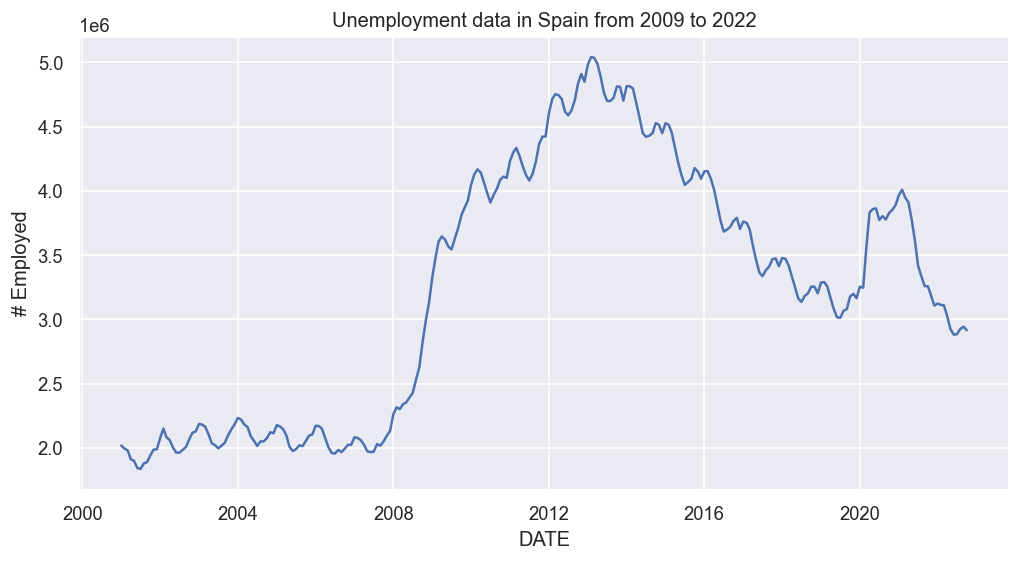

In [73]:
# Plotting a time series
#Plot bigger
plt.rcParams.update({'figure.figsize': (10, 5), 'figure.dpi': 120})
fig, ax = plt.subplots()
ax.plot('TOTAL', data=df)
ax.set(title='Unemployment data in Spain from 2009 to 2022', xlabel='DATE', ylabel='# Employed')
plt.show()

This is the unemployment data for Spain from the beginning of 2009 until 2022. The peaks that are almost always repeated would be the seasonal component. Looking at this component, we can see that we would be interested in the additive component, as the seasonal component remains constant.

Due to the fact of 2008 crisis (figure 3), the unemployment figures rises
until 2013 when unemployment figures started to go down. Therefore, all
previous months since 2011 will be removed from datasets because they do
not follow the tendency and no useful information can be obtained using
them

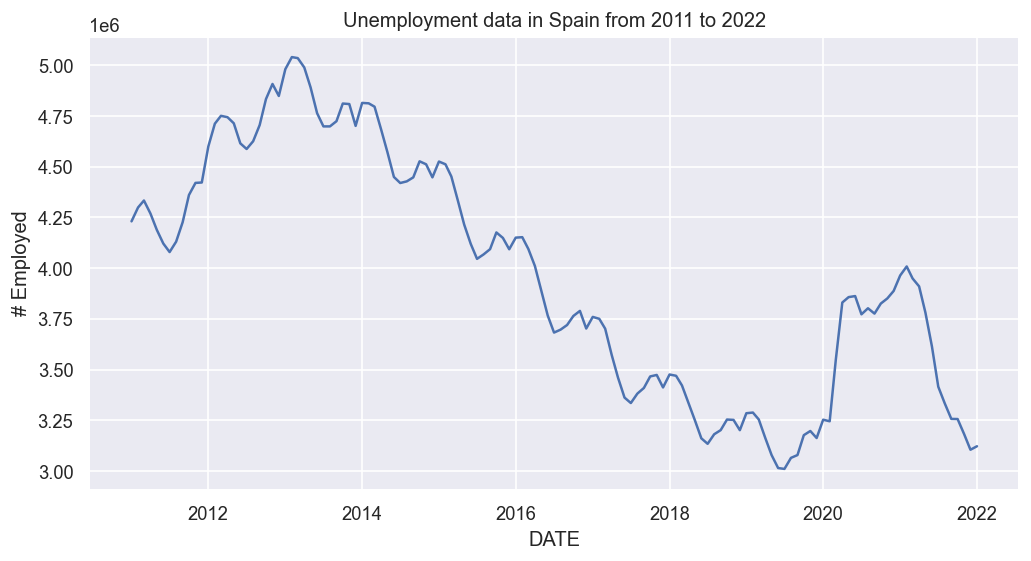

In [74]:
#Plot years 2011 to 2022
fig, ax = plt.subplots()
plt.rcParams.update({'figure.figsize': (10, 5), 'figure.dpi': 120})
ax.plot('TOTAL', data=df.loc['2011-01-01':'2022-01-01'])
ax.set(title='Unemployment data in Spain from 2011 to 2022', xlabel='DATE', ylabel='# Employed')
plt.show()

Moreover, there is a tendency, the unemployment figures descend in summer and when summer finishes, the unemployment figures rise until November, because many people are hired due to Christmas.


---
## 2. Sesonal ARIMA Model
Now, a Seasonal ARIMA will be studied. First of all, some tranformations
must be done to achieve constant variance and mean

In [75]:
df_ts = df[['TOTAL']].iloc[df.index>="2011-01-01"]# Maintain data.frame format for column
df_ts

,TOTAL
DATE,
2011-01-01,4231003
2011-02-01,4299263
2011-03-01,4333669
2011-04-01,4269360
2011-05-01,4189659
...,...
2022-06-01,2880582
2022-07-01,2883812
2022-08-01,2924240


---
### Identification process

#### 2.1. Plot the series and search for possible outliers

c:\Users\victor\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


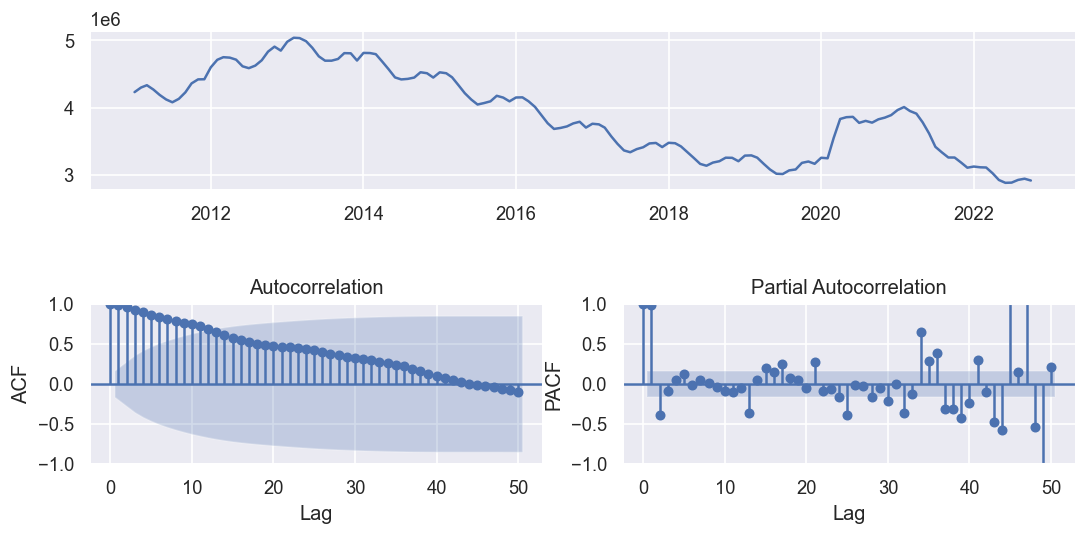

In [76]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(df_ts,lags=50)

---
#### 2.2. Stabilize the variance (if needed)

Firstly, it has to be checked that this dataset has a constant variance.

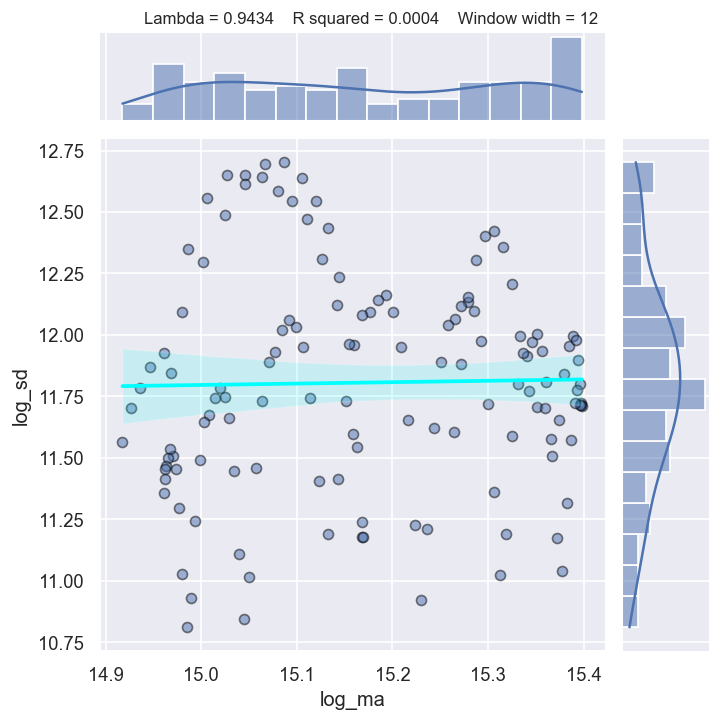

0.9434431704405695

In [77]:
# Box-Cox transformation
FT.boxcox_lambda_plot(df_ts, window_width=12)# window witdh can be changed later

In the above figure, it can be observed that this dataset has to be stabilized.
Therefore, a Box-Cox transformation will be used with a $\lambda$ = 0.9434 to
stabilize variance. The result can be analyzed below, the variance has been
stabilized

c:\Users\victor\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


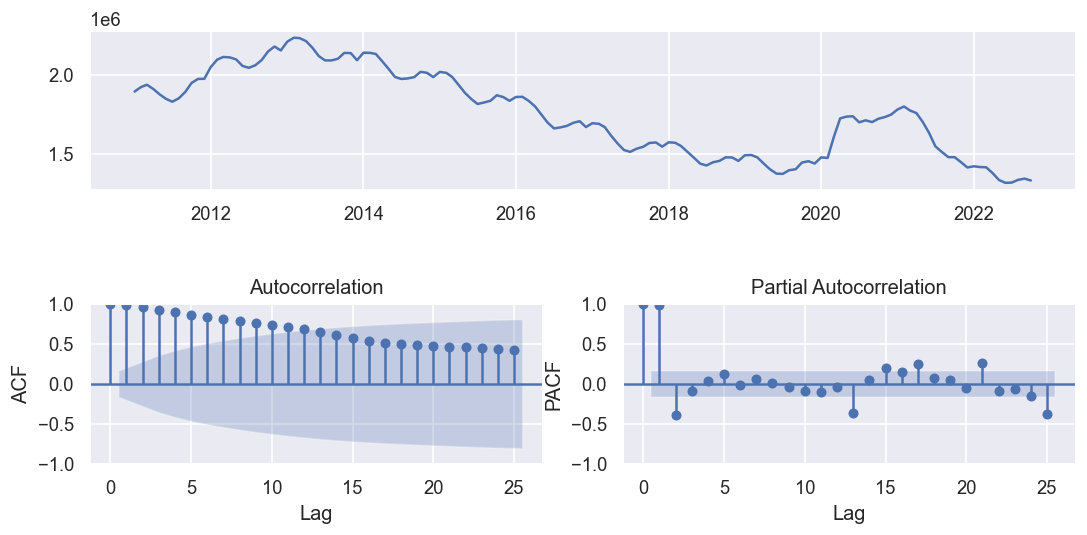

In [78]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    lmbda = 0.9434431704405695 #Select lambda
    z = st.boxcox(df_ts.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df_ts.values[:,0] - min(df_ts.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=df_ts.columns.values.tolist(),index=df_ts.index)
else:
    z = df_ts

# Plot transformed data
FT.ts_display(z)

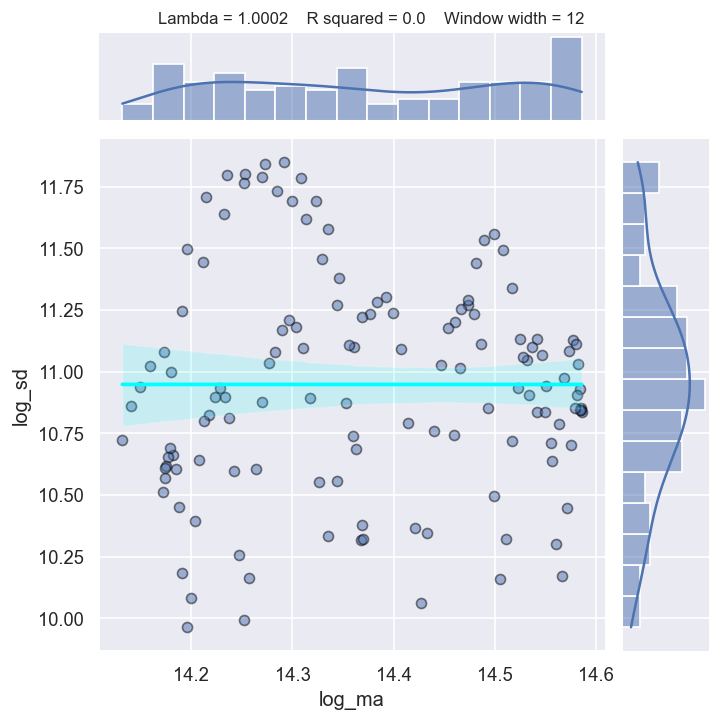

1.0002498449177173

In [79]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

---
#### 2.3. Analyze stationarity 

Now, the trend will be studied to know wether is stationary or not. It can be observed that is not stationary. Futhermore, the ACF plot has a linear trend. Hence, it will be used differencing to make the series stationary.

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v1.png' style='width:1000px;'/></td></tr></table>

When differencing is applied, the results are as follows:

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v2.png' style='width:1000px;'/></td></tr></table>


0, the trend is centered on 0, but seasonality of period 12 is
evidenced in the ACF and PACF plots, therefore it may require seasonal
differencing.

c:\Users\victor\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


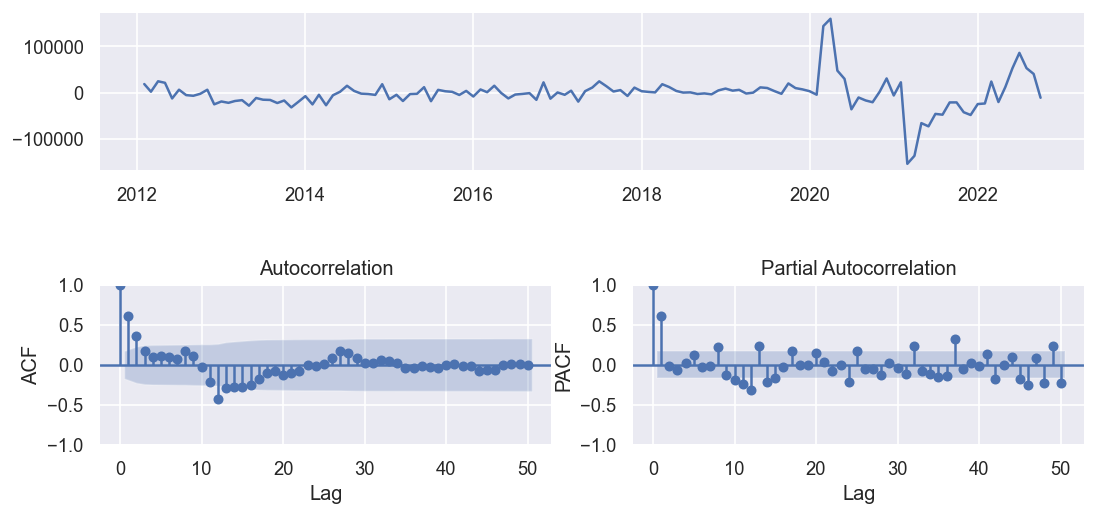

In [80]:
d = 1 # 
D = 1 # 
S = 12 #

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

When seasonal differencing is applied, the above plot shows that the trend
is stationary and centered on 0. However, it can be observed that there is a
peak at the beginning of 2020 due to coronavirus crisis.


In [81]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.257661
p-value: 0.648313
Critical Values:
	1%: -3.483
	5%: -2.884
	10%: -2.579


---
#### 2.4. Fit ARIMA model and check significance of the coefficients

In addition, a SARIMA model will be fitted, but order and seasonal order
must be found.

The order is formed of 3 values, (p, d, q). p is the autoregressive process
value that can be found in the first period in the PACF plot. Aproximately,
it should be 1 since only the first coefficient of the correlogram shows an
appreciable significance. d is the differencing value, it was determined that it
was needed regular differencing. q is the moving average process value that
can be found in ACF plot. It would be aproximately 2 due to the fact that
only the first two coefficients appear to be significant.

The seasonal order is formed of 4 values, (P, D, Q, S), P and Q are calculated observing wether there is a periodic tendency in PACF and ACF
plots. There are 2 periodic tendencies in PACF plot (P=2) and one periodic
tendency in ACF plot(Q=1). D is the seasonal differencing and it has to be
1 (it was discussed above). S is the period, it is 12 in this case.
Taking into account what has been said, and making different variations
looking for the optimal model, it has been obtained that:


In [82]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, # ponemos la serie, con o sin transformacion
                    order=(0,1,2), # Regular components (p,d,q)
                    seasonal_order=(0, 1, 1, 12), # Seasonal components (P,D,Q,S) 
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=False, 
                    enforce_stationarity=False).fit()

print(sarima_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                TOTAL   No. Observations:                  142
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -1322.297
Date:                              Mon, 20 Mar 2023   AIC                           2652.595
Time:                                      23:44:21   BIC                           2663.539
Sample:                                  01-01-2011   HQIC                          2657.036
                                       - 10-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.5624      0.053     10.682      0.000       0.459       0.666
ma.L2          0.33

c:\Users\victor\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\victor\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


It can be observed that it has been chosen an order of (0,1,2) and a
seasonal order of (0,1,1,12) to minimize AIC. The $p_{values}$ are small for this
model too.
Now, it will be analyzed the residual error.

In [83]:
sarima_fit.aic

2652.594577251849

---
#### 2.5. Analyze residuals

There are not significant autocorrelation coefficients in the above figure.
Finally, the evolution of the predictions in the last months is shown, as
well as the unemployment figures in those months.

c:\Users\victor\anaconda3\envs\ml\lib\site-packages\mltools\forecast_tools.py:86: RuntimeWarning: invalid value encountered in true_divide
  y_pdf = y1 * y_pdf / np.max(y_pdf)
c:\Users\victor\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  12.995043   0.976562


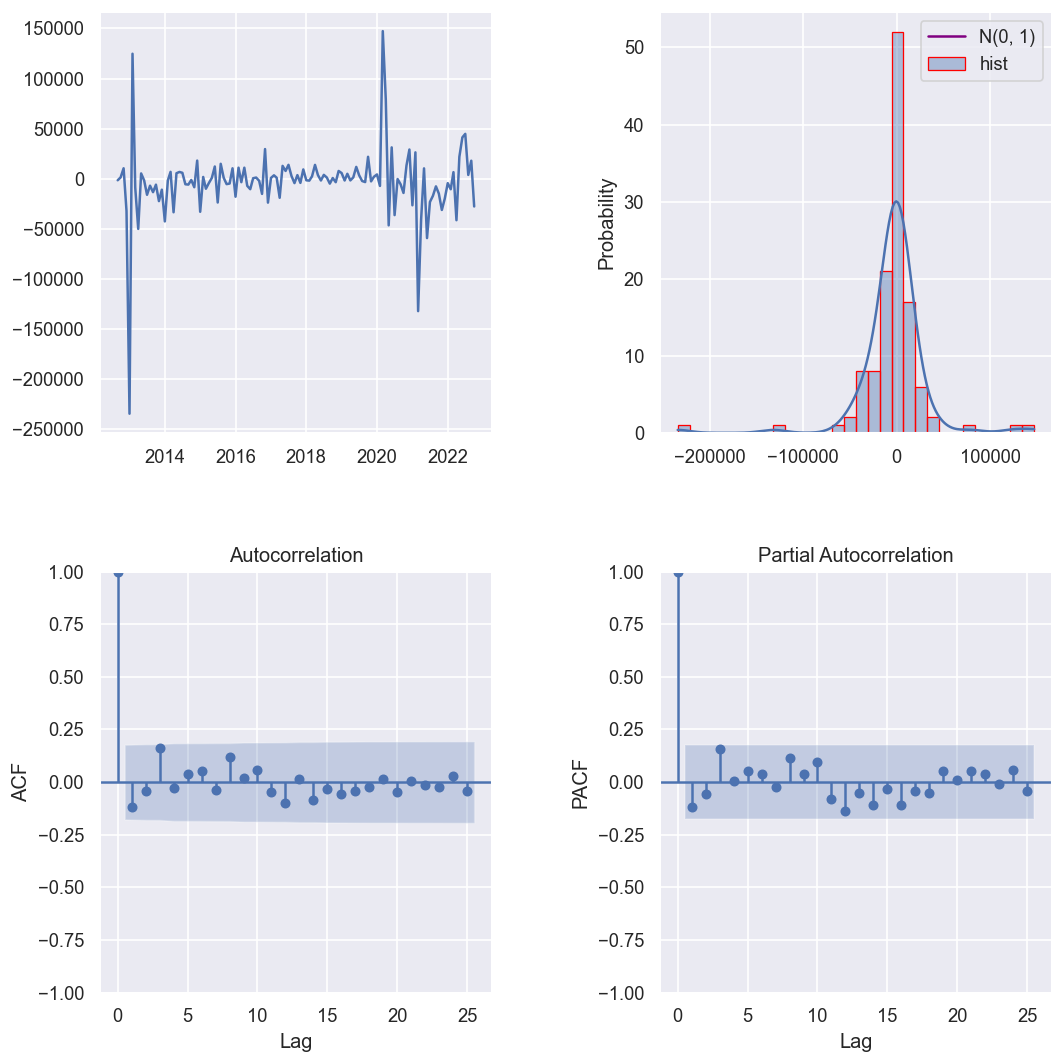

In [84]:
# Plot residual error
plt.figure(figsize=[10,10])
FT.check_residuals(pd.DataFrame(sarima_fit.resid.iloc[20:])) #COMENTAR QUITAR RESIDUOS DEBIDO A OUTLIER

---
#### 2.6. Predictions

The unemployment figure has been forecasted for November of 2022 with a 95 % confidence interval.

In [85]:
#Obtain forecasts for in-sample and out-of-sample
start = df_ts.shape[0]-2
horizon = 6
end = df_ts.shape[0] + horizon

pred = sarima_fit.get_prediction(start=start, end= end, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)



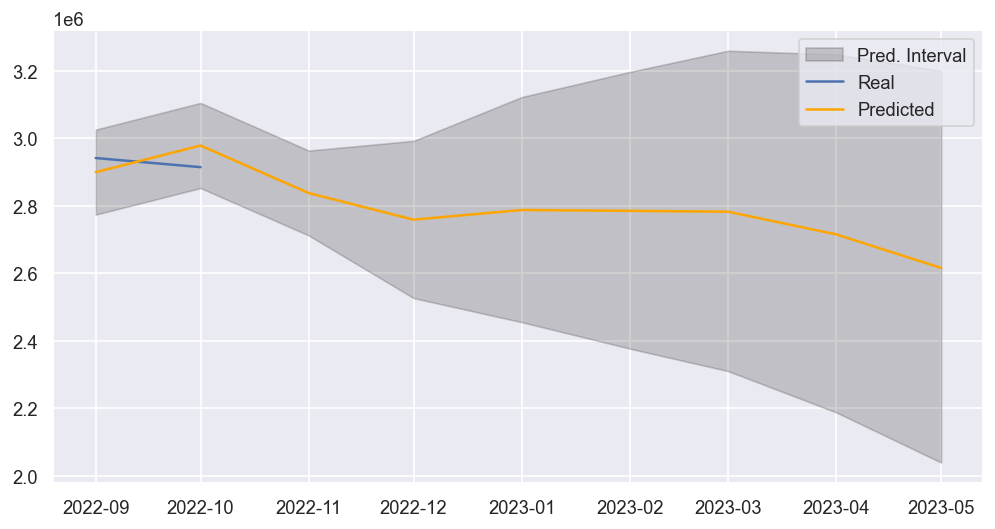

In [86]:
pred_index = [df_ts.index[start] + pd.DateOffset(months=m % 12) + pd.DateOffset(years = (m // 12)) for m in range(len(yhat))]
plt.figure()
plt.fill_between(pred_index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], 
                color='k', alpha=.2, label='Pred. Interval')
plt.plot(df_ts.iloc[start:], label='Real')
plt.plot(pred_index, yhat, color='orange', label='Predicted')
plt.legend()
plt.show()

In [87]:
yhat=sarima_fit.get_forecast('2022-11').predicted_mean

print(sp.special.inv_boxcox(yhat, lmbda))

2022-11-01    2.837967e+06
Freq: MS, dtype: float64


In [88]:
yhat_conf_int=sarima_fit.get_forecast('2022-11').conf_int(alpha=0.05)
print(sp.special.inv_boxcox(yhat_conf_int, lmbda))

             lower TOTAL   upper TOTAL
2022-11-01  2.712223e+06  2.964027e+06


To sum up:
$$
\quad\\
\begin{array}{|c|c|c|c|}
\hline
\text{Parameter} & \text{Minimum} & \text{Average} & \text{Maxime} \\
\hline
 \text{Unemployment Figure} & 2715676 &2836784 &2958186 \\
\hline 

\end{array}
\quad\\
$$

## 3. Seasonal ARIMAX model

Now, a Seasonal ARIMA using an intervetion variable will be studied. Due
to the 2008 crisis (figure 3), the unemployment figures rises until 2013 when
unemployment figures started to go down. Therefore, all previous months
since 2011 will be removed from datasets because they do not follow the
tendency and do not fit this model correctly.

First of all, some tranformations have to be done to achieve constant
variance and mean.

---
#### 3.1. Stabilize the variance.
Firstly, it has to be checked that this dataset has a constant variance.

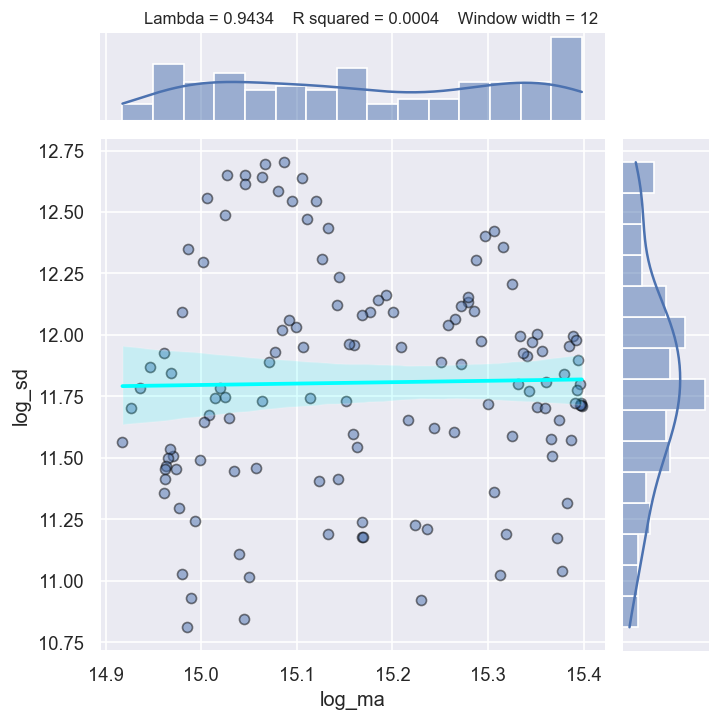

0.9434431704405695

In [89]:
# Box-Cox transformation
FT.boxcox_lambda_plot(df_ts, window_width=12)

In the above figure, it can be observed that this dataset has to be stabilized.
Therefore, a Box-cox transformation will be used with a $\lambda$ = 0.9434 to stabilize variance. The result can be analyzed below, the variance has been
stabilized.

c:\Users\victor\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


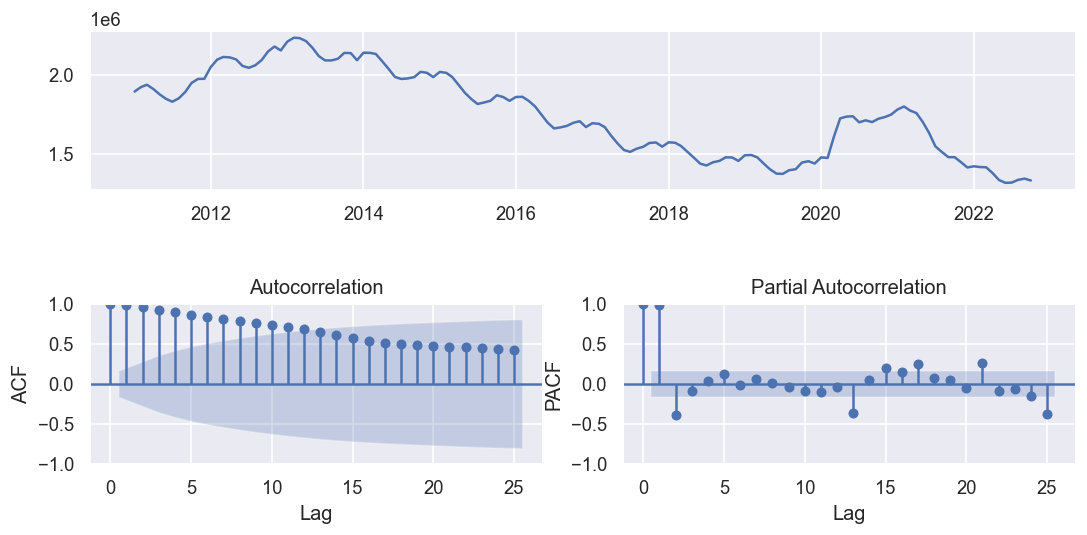

In [90]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    lmbda = 0.9434431704405695 #Select lambda
    z = st.boxcox(df_ts.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df_ts.values[:,0] - min(df_ts.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=df_ts.columns.values.tolist(), index=df_ts.index)
else:
    z = df_ts

# Plot transformed data
FT.ts_display(z)

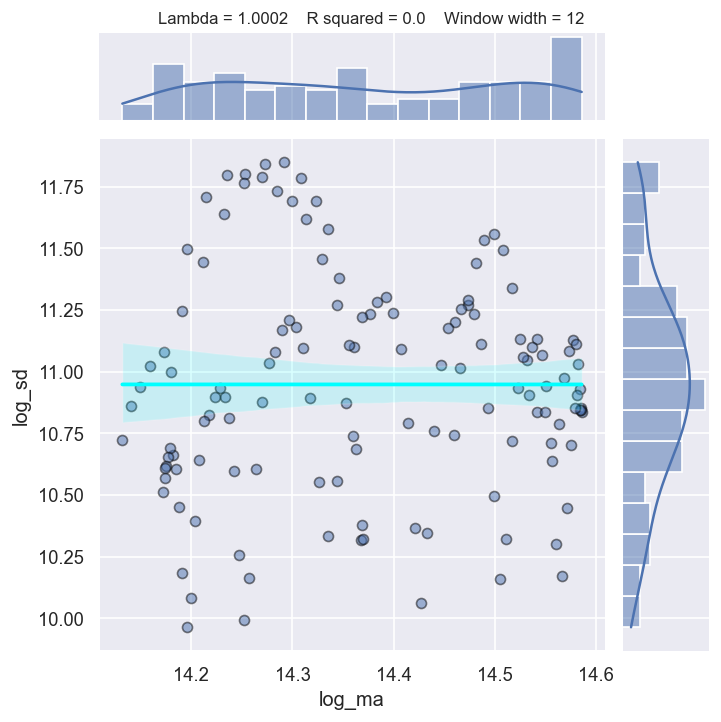

1.0002498449177173

In [91]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

---
#### 3.2. Analyze stationarity
Now, the trend will be studied to know whether it is stationary or not. It
can be observed that is not stationary. Futhermore, the ACF plot(figure 18)
has a linear trend. Hence, it will be used differencing to make the series
stationary.

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v3.png' style='width:1000px;'/></td></tr></table>

When differencing is applied, the results are as follows:

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v2.png' style='width:1000px;'/></td></tr></table>

In above figure, the trend is centered on 0, but seasonality of period 12 is
evidenced in the ACF and PACF plots, therefore it may require seasonal
differencing.

c:\Users\victor\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


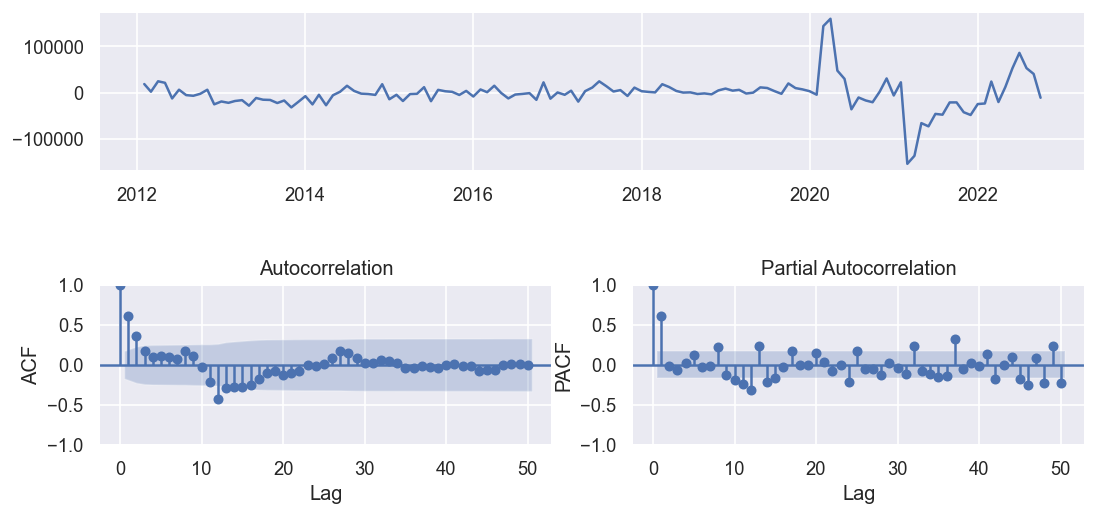

In [92]:
d =1 
D = 1 
S = 12 

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

When seasonal differencing is applied, the above plot shows that the trend
is stationary and centered on 0. However, it can be observed that there is a
peak at the beginning of 2020 due to coronavirus crisis and this event will
be used as an intervetion variable.

In [93]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.257661
p-value: 0.648313
Critical Values:
	1%: -3.483
	5%: -2.884
	10%: -2.579


---
#### 3.3. Fit ARIMAX model and check significance of the coefficients

#### 3.3.1. Creation of variable covid


In [94]:
covid=pd.DataFrame({'COVID':np.zeros(len(z))},index=df_ts.index)
covid.loc[(covid.index>="2020-03-01") & (covid.index<="2021-02-01")]=1
covid=covid.astype(int)

#### 3.3.2 Fit model

In addition, as in the previous section, a SARIMA model will be fitted, which
means that order and seasonal order have to be found.
As it has already been explained,the order is formed of 3 values, (p, d, q).
p is the autoregressive process value that can be found in PACF plot. Aproximately, it should be 1. d (differencing value) will be 1 , since it was determined that it was needed regular differencing. q can be found in ACF plot.
It would be aproximately 2.
The seasonal order mst be also found, (P, D, Q, S), P and Q are calculated
observing wether there is a periodic tendency in PACF and ACF plots. There
are 2 periodic tendencies in PACF plot (P=2) and one periodic tendency in
ACF plot(Q=1). D (seasonal differencing) has to be 1 (it was discussed
above). S is the period, it is 12 as in the previous section.
Taking into account what has been said, and making different variations
looking for the optimal model, it has been obtained that:

In [95]:
# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(endog = z, 
                            order=(0,1,2), # Regular components (p,d,q)
                            seasonal_order=(0, 1, 1, 12), 
                            #order=(0,2,0),
                            #seasonal_order=(0,1,1,12),
                            exog= covid['COVID'],
                            enforce_invertibility=False, 
                            enforce_stationarity=False)
res_sarimax = mod_sarimax.fit()

# Show the summary of results
print(res_sarimax.summary())

                                      SARIMAX Results                                       
Dep. Variable:                                TOTAL   No. Observations:                  142
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -1309.533
Date:                              Mon, 20 Mar 2023   AIC                           2629.066
Time:                                      23:44:25   BIC                           2642.747
Sample:                                  01-01-2011   HQIC                          2634.618
                                       - 10-01-2022                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
COVID        7.93e+04   5618.011     14.115      0.000    6.83e+04    9.03e+04
ma.L1          0.54

c:\Users\victor\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\victor\anaconda3\envs\ml\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


It can be observed that it has been chosen an order of (0, 1, 2) and a
seasonal order of (0, 1, 1, 12) to minimize AIC. The pvalues are small for this
model.
Now, it will be analyzed the residual error

---
#### 3.4. Analyze residuals

Now, it will be analyzed the residual error.


c:\Users\victor\anaconda3\envs\ml\lib\site-packages\mltools\forecast_tools.py:86: RuntimeWarning: invalid value encountered in true_divide
  y_pdf = y1 * y_pdf / np.max(y_pdf)
c:\Users\victor\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  10.683584   0.994361


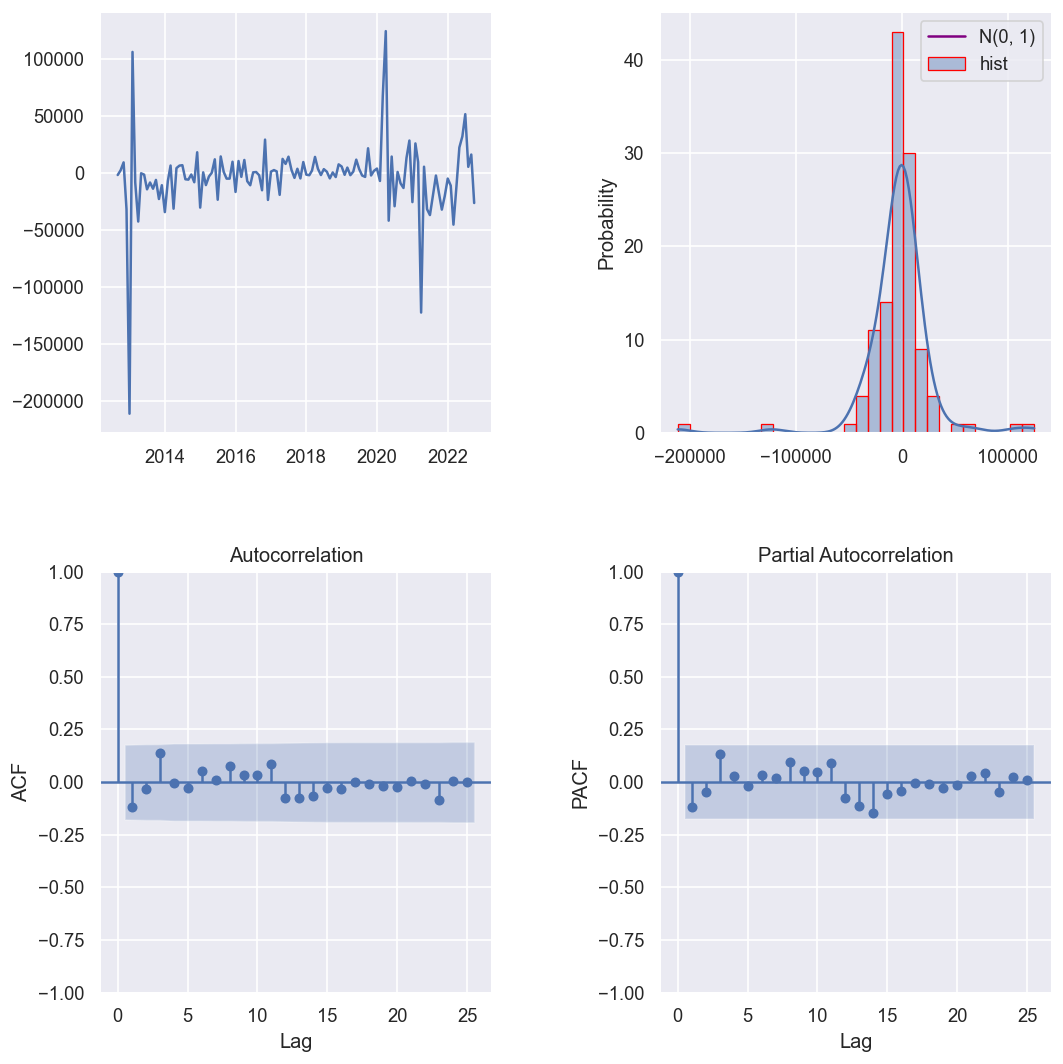

In [96]:
# Plot residual error
plt.rcParams.update({'figure.figsize': (10, 10), 'figure.dpi': 120})
FT.check_residuals(pd.DataFrame(res_sarimax.resid[20:]),lags=25)

There are not significant autocorrelation coefficients in above figure.

---
#### 3.5 Predictions

Finally, the evolution of the predictions in the last months is shown, as
well as the unemployment figures in those months.

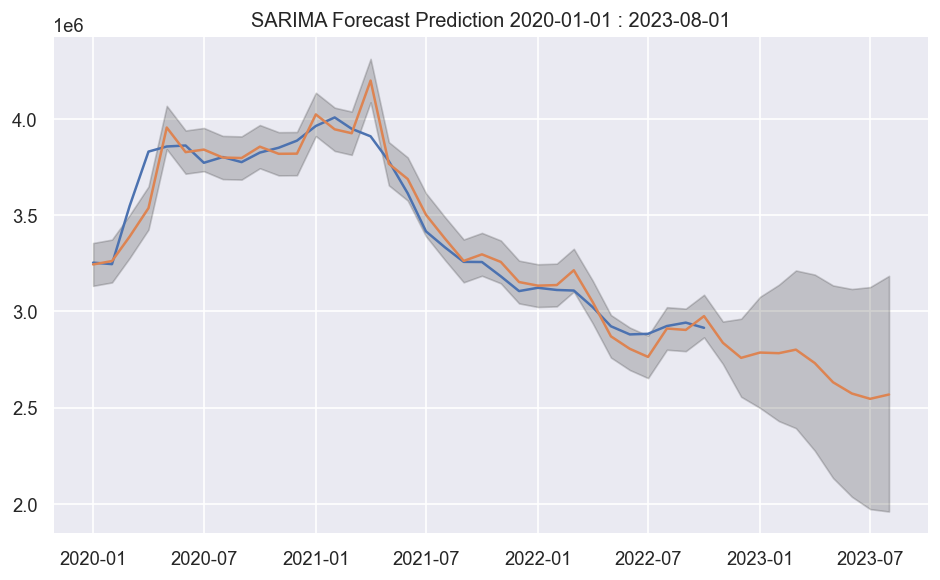

In [97]:
#Obtain forecasts for in-sample and out-of-sample
#start = 10
#horizon = 20
#end = df_ts.shape[0] + horizon
start="2020-01-01"
start=datetime.strptime(start, '%Y-%m-%d')
horizonori=10
horizon=pd.DateOffset(months=horizonori)
end=df_ts.index[-1]+horizon

covid_forecast=covid.copy()
covid_forecast=covid_forecast.reindex(df_ts.index + pd.DateOffset(months=horizonori)).fillna(0)

pred = res_sarimax.get_prediction(start=start,exog =covid_forecast.iloc[-horizonori:], end=end , dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)


plt.figure(figsize=[8,5])
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(df_ts.loc[start:])
plt.plot(yhat)
plt.title('SARIMA Forecast')
plt.title(f'SARIMA Forecast Prediction {datetime.strftime(start, "%Y-%m-%d")} : {datetime.strftime(end, "%Y-%m-%d")}')
plt.tight_layout()
plt.show()

In [98]:
yhat=res_sarimax.get_forecast('2022-11',exog=covid_forecast.loc["2022-11"]).predicted_mean

print(sp.special.inv_boxcox(yhat, lmbda))

2022-11-01    2.836989e+06
Freq: MS, dtype: float64


In [99]:
yhat_conf_int=res_sarimax.get_forecast('2022-11',exog=covid_forecast.loc["2022-11"]).conf_int(alpha=0.05)
print(sp.special.inv_boxcox(yhat_conf_int, lmbda))



             lower TOTAL   upper TOTAL
2022-11-01  2.726605e+06  2.947617e+06


To sum up:
$$
\quad\\
\begin{array}{|c|c|c|c|}
\hline
\text{Parameter} & \text{Minimum} & \text{Average} & \text{Maxime} \\
\hline
 \text{Unemployment Figure} &2728951 &2836733& 2944748 \\
\hline 

\end{array}
\quad\\
$$

---
## 4. Non linear forecast

In this section, non-linear methods will be applied to try to forecast unemployment in Spain in the month of November. These models will receive as
input variables the unemployment values for the months prior to the month
to be predicted, in addition to the exogenous variable Covid, which will be
defined in the same way as in the SARIMAX model

In [115]:
dfnl = pd.read_csv('UnemploymentSpain.dat',sep='\t')    #parse_dates=['DATE'], dayfirst=True, sep='\t', index_col='DATE')
dfnl=dfnl[95:262]
dfnl['TOTAL_lag'] = dfnl['TOTAL'].shift()
dfnl['TOTAL_lag12'] = dfnl['TOTAL'].shift(12)
dfnl['TOTAL_lag13'] = dfnl['TOTAL'].shift(13)
dfnl['TOTAL_lag24'] = dfnl['TOTAL'].shift(24) 
dfnl['TOTAL_lag25'] = dfnl['TOTAL'].shift(25)
#dfnl['TOTAL_lag36'] = dfnl['TOTAL'].shift(36) #poner lag3,lag6,lag9,lag12 
#dfnl['TOTAL_lag48'] = dfnl['TOTAL'].shift(48)
dfnl.dropna(inplace=True)
dfnl['COVID']=(dfnl.index>229) & (dfnl.index<241)
dfnl.astype({'COVID':'int64'})

,DATE,TOTAL,TOTAL_lag,TOTAL_lag12,TOTAL_lag13,TOTAL_lag24,TOTAL_lag25,COVID
120,01/01/2011,4231003,4100073.0,4048493.0,3923603.0,3327801.0,3128963.0,0
121,01/02/2011,4299263,4231003.0,4130625.0,4048493.0,3481859.0,3327801.0,0
122,01/03/2011,4333669,4299263.0,4166613.0,4130625.0,3605402.0,3481859.0,0
123,01/04/2011,4269360,4333669.0,4142425.0,4166613.0,3644880.0,3605402.0,0
124,01/05/2011,4189659,4269360.0,4066202.0,4142425.0,3620139.0,3644880.0,0
...,...,...,...,...,...,...,...,...
257,01/06/2022,2880582,2922911.0,3614339.0,3781250.0,3862883.0,3857776.0,0
258,01/07/2022,2883812,2880582.0,3416498.0,3614339.0,3773034.0,3862883.0,0
259,01/08/2022,2924240,2883812.0,3333915.0,3416498.0,3802814.0,3773034.0,0
260,01/09/2022,2941919,2924240.0,3257802.0,3333915.0,3776485.0,3802814.0,0


---
#### 4.1 MLP Forecast

As it was said, MLP technique is one of the models that will be used to
forecast unemployment. Following the same thinking that previous sections,
all data from before 2011 will be removed from the dataset.
Regarding the input variables, in addition to COVID, several variables
of unemployed lagged x months have been chosen. To be exact, the lagged
variables chosen are unemployment lag 1 time, unemployment lag 12 times ,
unemployment lag 13 times, unemployment lag 24 times and unemployment
lag 25 times.
After knowing which data will be used, the MLP model will be developed.
First of all, it will be reviewed which hyperparameters are optimal for this
model.


In [116]:
# Define input and output matrices
OUTPUT = 'TOTAL'
INPUTS=['COVID','TOTAL_lag','TOTAL_lag13','TOTAL_lag12','TOTAL_lag24','TOTAL_lag25']
# We have categorical inputs with many classes. We will create dummy variables automatically after
X = dfnl[INPUTS]
y = dfnl[OUTPUT]

# Split data into train and test
X_train = X.iloc[0:round(0.8*X.shape[0])]
X_test = X.iloc[round(0.8*X.shape[0])+1:X.shape[0]]
y_train = y.iloc[0:round(0.8*X.shape[0])]
y_test = y.iloc[round(0.8*X.shape[0])+1:X.shape[0]]

# Create a copy of the dataframes for evaluation
dfTR_eval = X_train.copy()
dfTR_eval['Y'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['Y'] = y_test # We will call Y as output variable for simplicity


As it can be seen, the optimal hyperparameters are alpha=10−6 and two
layers of 13 and 5 neurons. After this, it will look for which variables are
important to this model.

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v4.png' style='width:500px;'/></td></tr></table>

In [117]:
#------------------------------- MLP Regression MODEL -------------------------------------------------
INPUTS_MLP_NUM =['TOTAL_lag','TOTAL_lag13','TOTAL_lag12','TOTAL_lag24','TOTAL_lag25']
INPUTS_MLP_CAT = ['COVID'] #Weekday is numerical in this case - Intervention variables
INPUTS_MLP = INPUTS_MLP_NUM + INPUTS_MLP_CAT

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Prepare the categorical variables by encoding the categories
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM),
        ('cat', categorical_transformer, INPUTS_MLP_CAT)
        ])

# Define the grid of parameters to search in
param = {'MLP__alpha': [0.000001], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(13,5)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='lbfgs', # Update function
                activation='relu', # Logistic sigmoid activation function
                max_iter=450, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS_MLP], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['TOTAL_lag',
                                                                          'TOTAL_lag13',
                                                                          'TOTAL_lag12',
                                                                          'TOTAL_lag24',
                                                                          'TOTAL_lag25']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('onehot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['COVID'])])),
                                       ('MLP',
                                        MLPRegressor(max_iter=450,
                                                     random_state=150,
                                                     solver='lbfgs',
                                                     verbose=True))]),
             n_jobs=-1,
             param_grid={'MLP__alpha': [1e-06],
                         'MLP__hidden_layer_sizes': [(13, 5)]},
             scoring='neg_mean_squared_error')

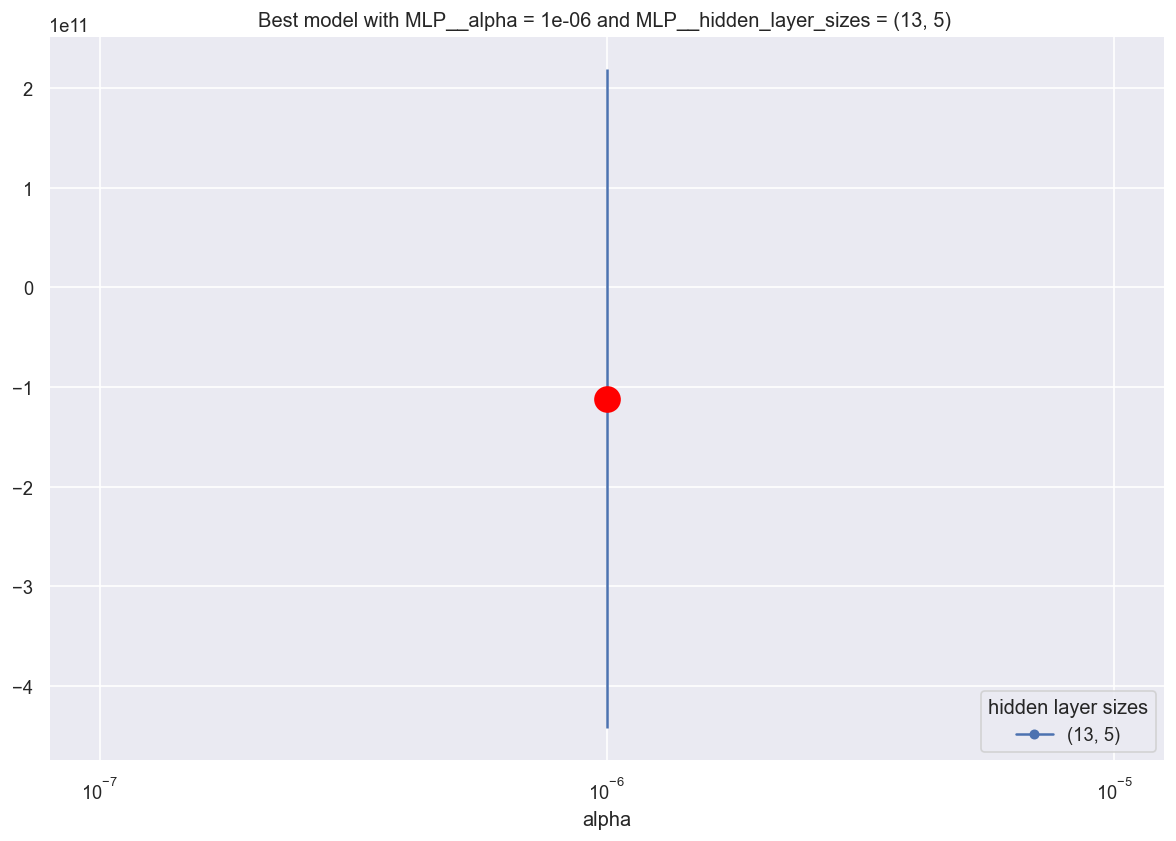

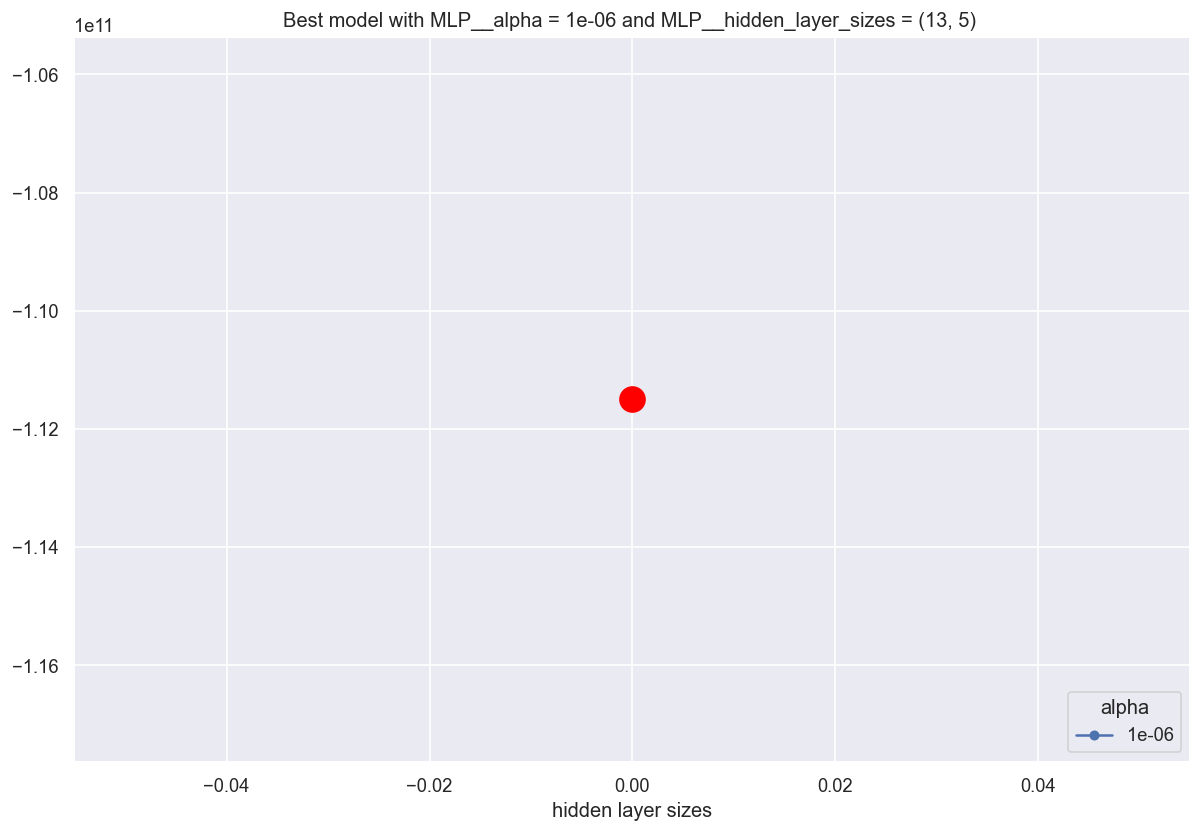

In [118]:
# Plot the cross validation score in the Grid Search
MT.plotModelGridError(MLP_fit, xscale="log")

In [119]:
# SENSITIVITY ANALYSIS
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
#actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
actfunc = ['identity','relu','relu',mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS_MLP)

X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train, columns=['Y'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

#Compute sensitivities
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)
sensmlp.summary()
#sensmlp.info()

Sensitivity analysis of [7, 13, 5, 1] MLP network.

Sensitivity measures of each output:

$Y 

                          mean            std  mean_squared
num__TOTAL_lag    6.098376e+05  123923.307612  6.223013e+05
num__TOTAL_lag13 -2.882739e+05   31886.633635  2.900320e+05
num__TOTAL_lag12  2.013901e+05   74280.469504  2.146522e+05
num__TOTAL_lag24  2.509395e+05   51984.191477  2.562674e+05
num__TOTAL_lag25 -2.367425e+05   12679.353464  2.370818e+05
cat__COVID_False  1.520504e+06  318410.905566  1.553485e+06
cat__COVID_True   8.572122e+05   51737.568181  8.587721e+05


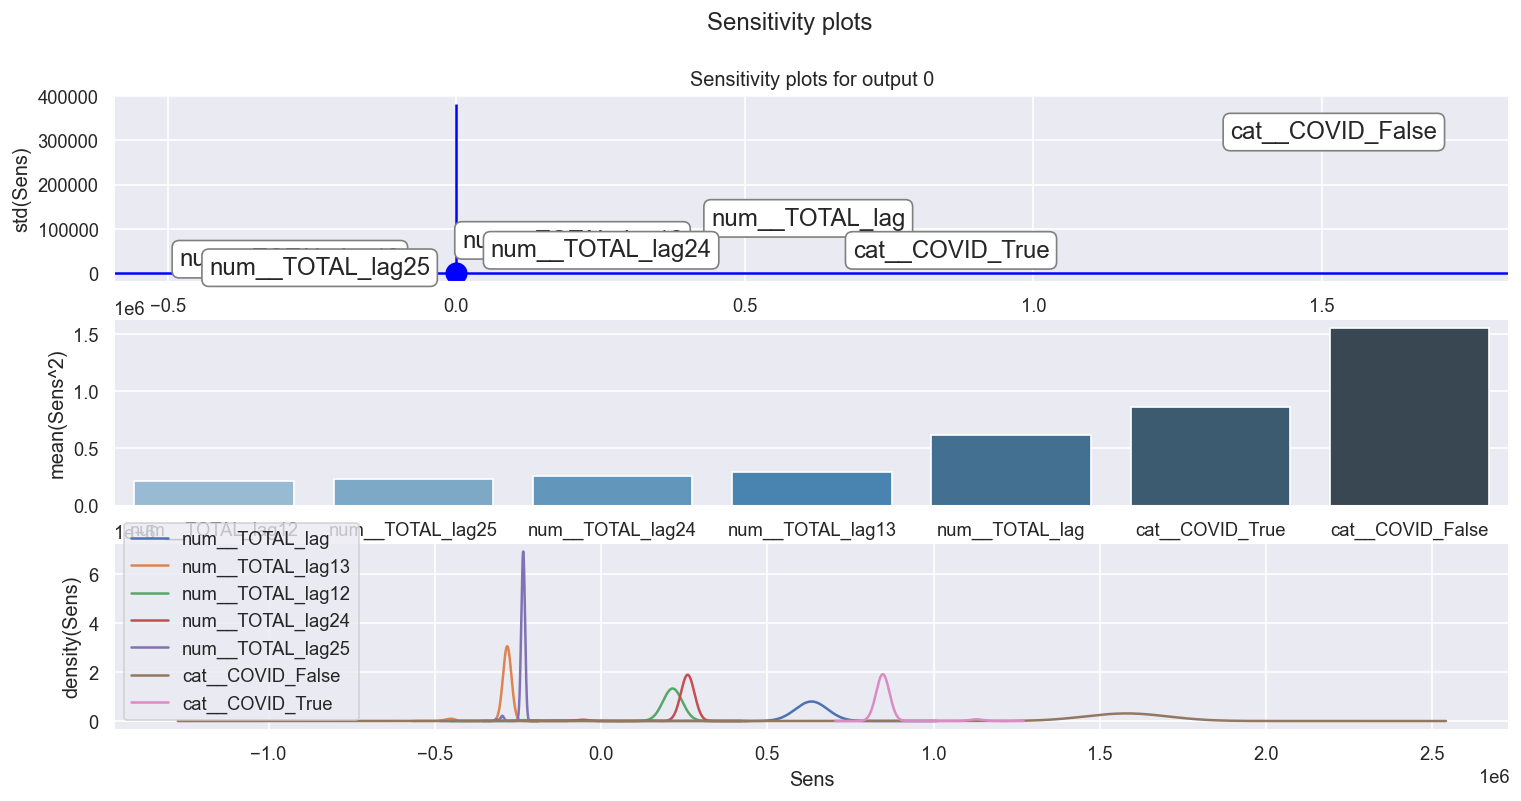

In [120]:
plt.rcParams["figure.figsize"]=[15,7]
sensmlp.plot()

In the photo above it can be seen how important are the data of the
previous months chosen to the month whose unemployment is forecasted.
It can be appreciated that, in order to forecast unemployment in one month,
the unemployment data two years earlier do not seem to be important. However, the truth is that its elimination severely affects the residual, so they
will be kept in the model.

In [121]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['Y'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['Y'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['Y'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['Y'], dfTS_eval['MLP_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['Y'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['Y'], dfTS_eval['MLP_pred']))

Training MAE: 20356.502641493025
Test MAE: 76148.33134334067
Training RMSE: 29213.426249366712
Test RMSE: 104217.23271670632
Training R2: 0.9976597434119733
Test R2: 0.9329276258925937


The relationship between prediction and real values is apparently linear,
which indicates a correct performance of the model.

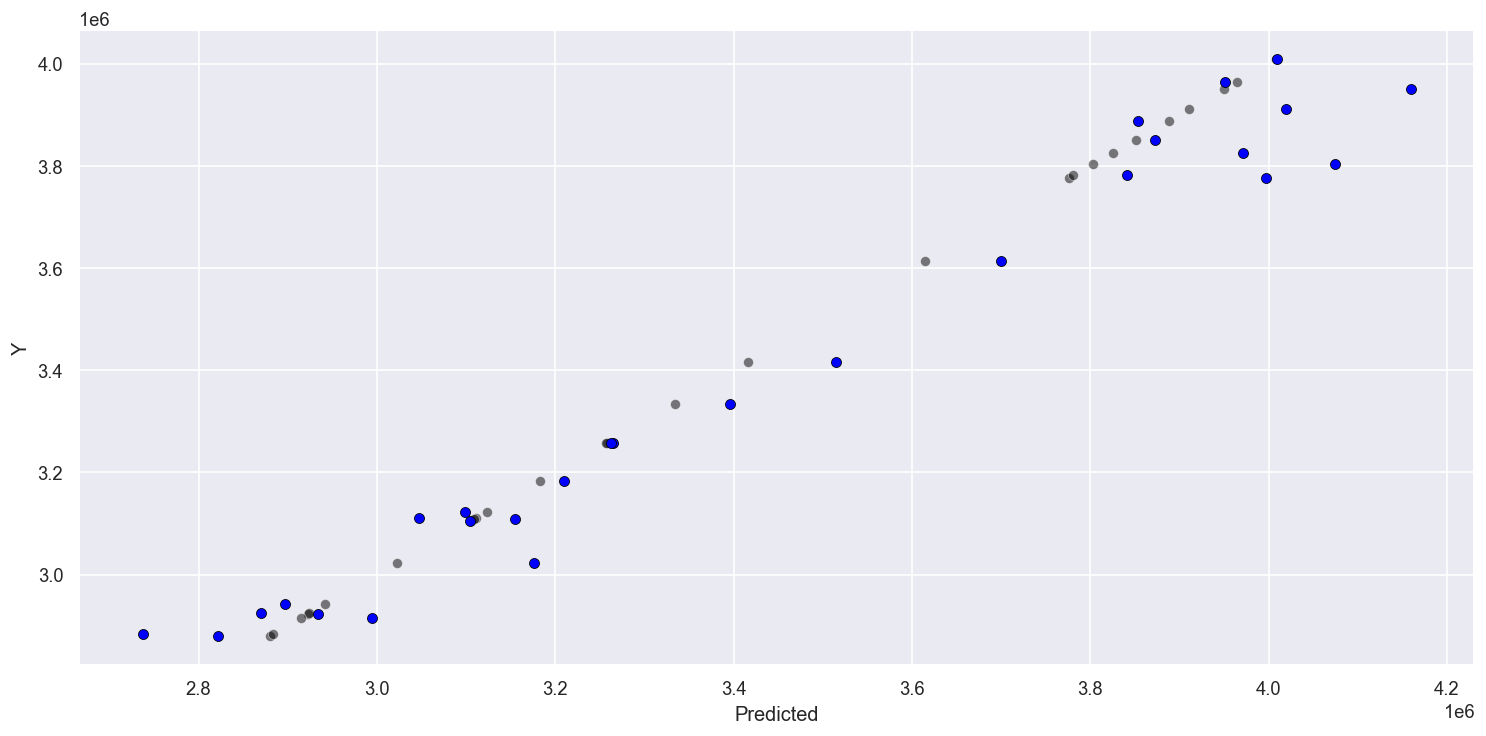

In [122]:
# Visualize prediction with respect to output
sns.scatterplot(data=dfTS_eval, x='Y', y='Y', color='black', alpha=0.5)
sns.scatterplot(data=dfTS_eval, x='MLP_pred', y='Y', color='blue', edgecolor='black')
plt.xlabel('Predicted')
plt.show()

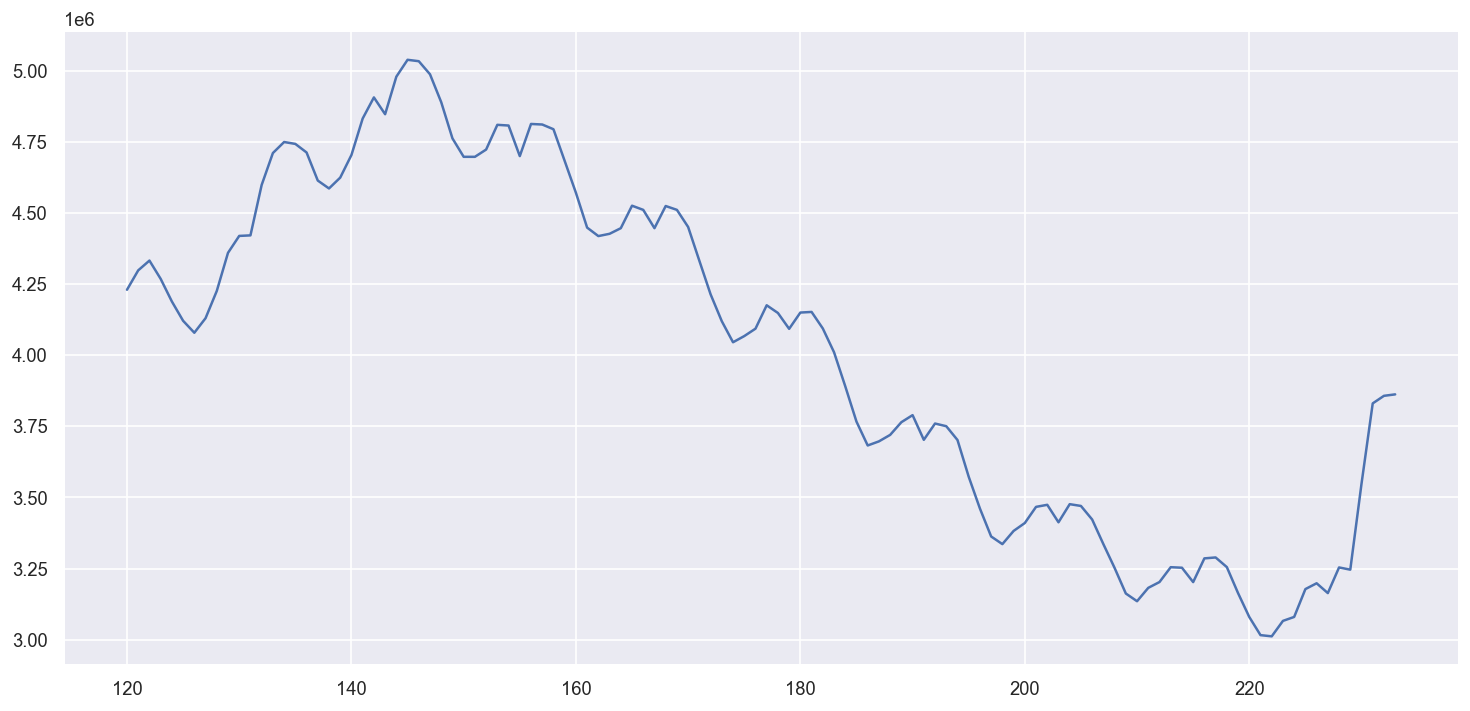

In [123]:
plt.plot(dfTR_eval['Y'])

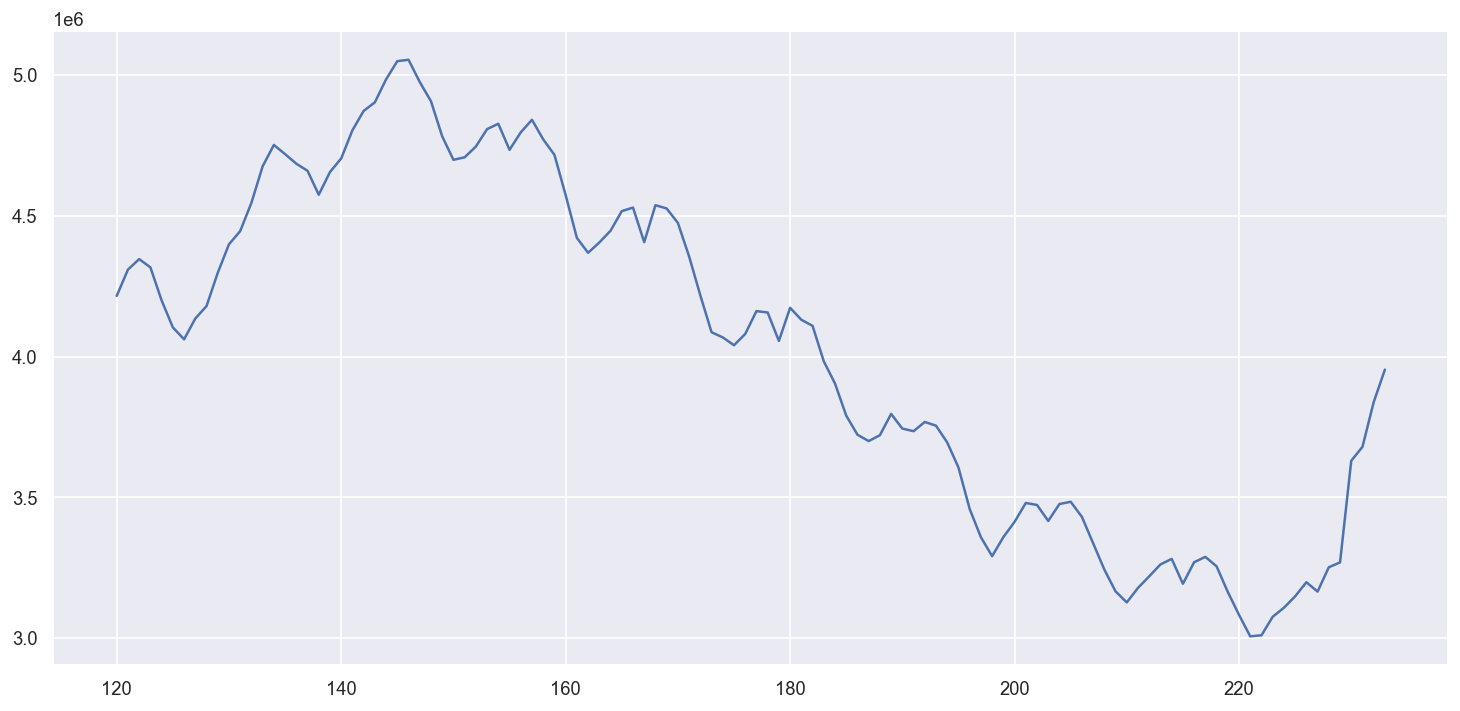

In [124]:
plt.plot(dfTR_eval['MLP_pred'])

There are not significant autocorrelation coefficients in below figure, which
means that the model is able to explain the trend practically in its entirety
since the correlogram of the residuals shows a white noise behavior

c:\Users\victor\anaconda3\envs\ml\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


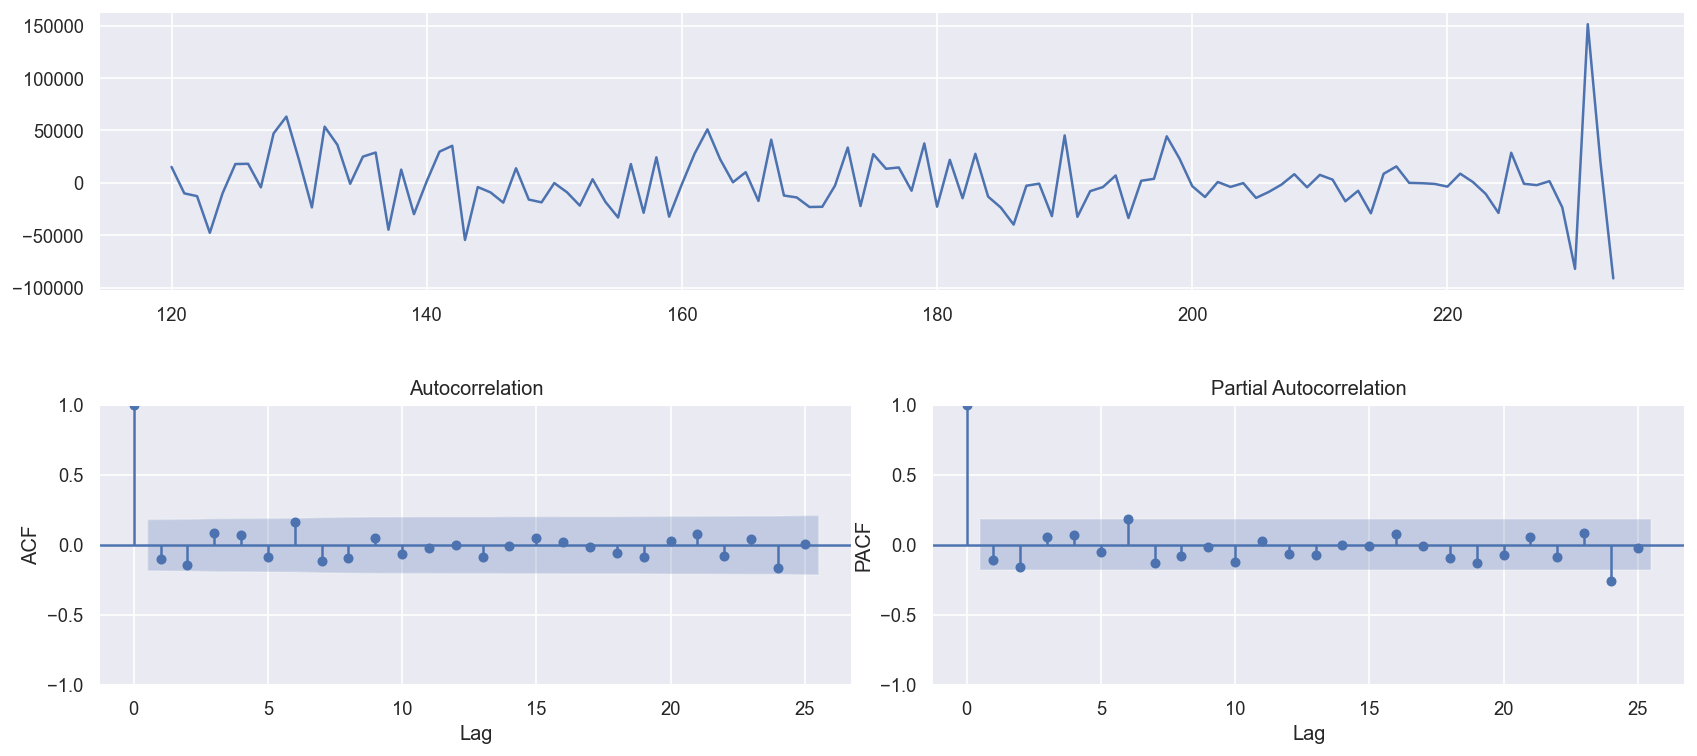

In [125]:
# Check correlation of residuals
FT.ts_display(dfTR_eval['Y'] - dfTR_eval['MLP_pred'])

In [126]:
dfTS_eval['MLP_pred'] 

235    4.074289e+06
236    3.997074e+06
237    3.971702e+06
238    3.872185e+06
239    3.853151e+06
240    3.951147e+06
241    4.009546e+06
242    4.159454e+06
243    4.019124e+06
244    3.841270e+06
245    3.700245e+06
246    3.515333e+06
247    3.396393e+06
248    3.264685e+06
249    3.262891e+06
250    3.209683e+06
251    3.104456e+06
252    3.099019e+06
253    3.047044e+06
254    3.154673e+06
255    3.175626e+06
256    2.933779e+06
257    2.822175e+06
258    2.737128e+06
259    2.870246e+06
260    2.897406e+06
261    2.994456e+06
Name: MLP_pred, dtype: float64

In [127]:
dfnl['TOTAL'][246]

3416498

In [128]:
dfnl_forecast=dfnl = pd.read_csv('UnemploymentSpain.dat',sep='\t') 
dfnl_forecast=dfnl_forecast.reindex(dfnl.index + 1).fillna(0)
dfnl_forecast['TOTAL_lag'] = dfnl_forecast['TOTAL'].shift()
dfnl_forecast['TOTAL_lag12'] = dfnl_forecast['TOTAL'].shift(12)
dfnl_forecast['TOTAL_lag13'] = dfnl_forecast['TOTAL'].shift(13)
dfnl_forecast['TOTAL_lag24'] = dfnl_forecast['TOTAL'].shift(24) 
dfnl_forecast['TOTAL_lag25'] = dfnl_forecast['TOTAL'].shift(25)
dfnl_forecast.dropna(inplace=True)
dfnl_forecast['COVID']=(dfnl_forecast.index>229) & (dfnl_forecast.index<241)
dfnl_forecast.astype({'COVID':'int64'})
dfnl_forecast.drop(['DATE','TOTAL'], axis=1,inplace=True)
Noviembre=dfnl_forecast.loc[dfnl_forecast.index==262]
Desempleonoviembre= MLP_fit.predict(Noviembre)
Desempleonoviembre[0].astype(int)

2927662

To sum up:
$$
\quad\\
\begin{array}{|c|c|}
\hline
\text{Parameter} & \text{Prediction}  \\
\hline
 \text{Unemployment Figure} & 2927662  \\
\hline 

\end{array}
\quad\\
$$

---
## 5. Conclusion

First, residuals will be compared, SARIMA and SARIMAX residual comparison.

<style>.container {width:100% !important; }</style>

<table><tr><td><img src='./images/v5.png' style='width:1000px;'/></td></tr></table>

As can be seen, they show similar behavior. However, SARIMAX shows aslight improvement in the residue.To check if there is really an improvement
in SARIMAX, the AIC will be used.

$$
\quad\\
\begin{array}{|c|c|c|c|}
\hline
\text{Model} & \text{Sarima} & \text{Sarimax}  \\
\hline
 \text{AIC} & 2652.595 & 2629.066  \\
\hline 

\end{array}
\quad\\
$$

The AIC shows that, as before, SARIMAX has a slight improvement over
SARIMA. Finally, the prediction will be checked in November, since there is
always a drop in unemployment at Christmas time, and the one that drops
the most will be considered more likely to be correct.

$$
\quad\\
\begin{array}{|c|c|c|c|}
\hline
\text{Model} & \text{Sarima} & \text{Sarimax} & \text{MLP}  \\
\hline
 \text{AIC} & 2836784 & 2836733 & 2927662  \\
\hline 

\end{array}
\quad\\
$$

Regarding the quality of these results, it is noteworthy to comment on
the improvement in the quality of the residuals that was had when the Covid
variable began to be added. In addition, it was observed that in the case of
the SARIMAX, less correlated residuals are obtained than in the other cases.
It is for this reason that it has been decided to rely on the SARIMAX
model to predict unemployment in Spain in November.
